<a href="https://colab.research.google.com/github/TheDuyIT/MachineTranslation/blob/master/src/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install -q tfds-nightly
# !pip install tensorflow-gpu

In [51]:
!npx degit TheDuyIT/MachineTranslation -f

npx: installed 1 in 1.004s
> destination directory is not empty. Using --force, continuing
> cloned TheDuyIT/MachineTranslation#master


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import tensorflow_datasets as tfds
import tensorflow as tf
import unicodedata
import time
import re
import numpy as np
import matplotlib.pyplot as plt
from src.process_data import DataFormatter, DataLoader
import jieba

## Setup input pipeline

In [54]:
loader = DataLoader()

In [55]:
content_en = loader.np_load('lst_cn_all_except_1001')
content_vn = loader.np_load('lst_vi_all_except_1001')
content_en = loader.np_load('lst_cn')
content_vn = loader.np_load('lst_vi')
content_en = loader.np_load('lst_cn_all_with6k_except_1001')
content_vn = loader.np_load('lst_vi_all_with6k_except_1001')
def preproces_cn(s):
  return re.sub('\s+', ' ', ' '.join(s))
  seg_list = jieba.cut(s)
  return " ".join(seg_list)

for i in range(len(content_vn)):
  content_vn[i] = content_vn[i].lower()
  # content_en.append(i['en'].lower())
  # content_vn.append(i['vn'].lower())
for i in range(len(content_en)):
  content_en[i] = preproces_cn(content_en[i])
# content_en

In [56]:
content_en[123]

'再 大 的 伤 痛 ， 睡 一 觉 就 把 它 忘 了 。 背 着 昨 天 追 赶 明 天 ， 会 累 坏 了 每 一 个 当 下 。 边 走 边 忘 ， 才 能 感 受 到 每 一 个 迎 面 而 来 的 幸 福 。'

In [57]:
print(len(content_en))
print(len(content_vn))

14699
14699


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(content_en, content_vn, test_size=0.2, random_state=1)
X_val, y_val = [X_train[0]], [y_train[0]]

def create_dataset(x, y):
  a = tf.data.Dataset.from_tensor_slices(x)  # ==> [ 1, 2, 3 ]
  b = tf.data.Dataset.from_tensor_slices(y)
  ds = tf.data.Dataset.zip((a, b))
  ds = ds.shuffle(buffer_size = 1000)
  return ds

In [59]:
full_dataset = create_dataset(content_en, content_vn)
train_examples = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)
val_dataset = create_dataset(X_val, y_val)
# train_examples = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [60]:
# tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_en')
# tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_vn')
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en, _ in full_dataset), target_vocab_size=2**13)

tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (vn.numpy() for _, vn in full_dataset), target_vocab_size=2**13)

In [61]:
# for i in range(tokenizer_en.vocab_size):
#   print(f'{i} ----> {tokenizer_en.decode([i])}')

In [62]:
tokenizer_en.save_to_file('/content/drive/MyDrive/VinBigData/checkpoints_new/tokenizer_en')
tokenizer_vn.save_to_file('/content/drive/MyDrive/VinBigData/checkpoints_new/tokenizer_vn')

In [63]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

In [64]:
def encode(lang1, lang2):
  lang1 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang1.numpy()) + [tokenizer_en.vocab_size+1]

  lang2 = [tokenizer_vn.vocab_size] + tokenizer_vn.encode(
      lang2.numpy()) + [tokenizer_vn.vocab_size+1]
  
  return lang1, lang2

In [65]:
def tf_encode(en, vn):
  result_en, result_vn = tf.py_function(encode, [en, vn], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_vn.set_shape([None])

  return result_en, result_vn

In [66]:
MAX_LENGTH = 250


In [67]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [68]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_dataset.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

test_dataset = test_dataset.map(tf_encode)
test_dataset = test_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [69]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [70]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


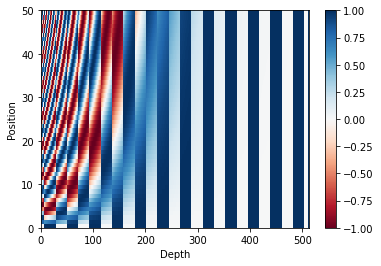

In [71]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [72]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [73]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [74]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Multi-head attention

In [75]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [76]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [77]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [78]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [79]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [80]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

In [81]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()
    
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Set hyperparameters

In [82]:
num_layers = 6
d_model = 256 # model dim
dff = 512 # feed forward dim
num_heads = 8 # number of multi head attention d_model%num_heads == 0

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_vn.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [83]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [84]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [85]:

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def accuracy_function(real, pred):
  # print('000000000000000000000000000')
  # print(real)
  # print('111111111111111111111111111')
  # print(pred)
  # print('222222222222222222222222222')
  # print(tf.argmax(pred, axis=2))
  # print('333333333333333333333333333')

  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  # print(accuracies)
  # print('333333333333333333333333333')
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
# def accuracy_function(real, pred):
#   candidate = tf.argmax(pred, axis=2)
#   # print(real.)
#   print(real.numpy()[0][:-1])
#   print(tokenizer_vn.decode(real.numpy()[0][:-1]))
#   print(candidate.numpy()[0][:-1])
#   print(tokenizer_vn.decode(candidate.numpy()[0][:-1]))
#   # print(candidate)
#   # score = bleu_score(real, candidate)
#   score = 12
#   print(score)
#   return tf.constant(score)
# # bleu_function('real', 'pred')


In [86]:
# dir(tokenizer_vn)

In [87]:
# for i in content_vn[:12]:
#   if 'mãnh_' in i:
#     print(i)  

In [88]:
# for i in range(100000):
#   print(tokenizer_vn._id_to_subword(i).encode('utf-8').decode('utf-8'))

In [89]:
from collections import Counter
import math
def n_gram_generator(sentence,n= 2,n_gram= False):
    '''
    N-Gram generator with parameters sentence
    n is for number of n_grams
    The n_gram parameter removes repeating n_grams 
    '''
    sentence = sentence.lower() # converting to lower case
    sent_arr = np.array(sentence.split()) # split to string arrays
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        word_range = list(range(i-n,i))
        s_list = sent_arr[word_range]
        string = ' '.join(s_list) # converting list to strings
        word_list.append(string) # append to word_list
        if n_gram:
            word_list = list(set(word_list))
    return word_list
def bleu_score(original,machine_translated):
    '''
    Bleu score function given a orginal and a machine translated sentences
    '''
    mt_length = len(machine_translated.split())
    o_length = len(original.split())

    # Brevity Penalty 
    if mt_length>o_length:
        BP=1
    else:
        penality=1-(mt_length/o_length)
        BP=np.exp(penality)

    # Clipped precision
    clipped_precision_score = []
    for i in range(1, 5):
        original_n_gram = Counter(n_gram_generator(original,i))
        machine_n_gram = Counter(n_gram_generator(machine_translated,i))

        c = sum(machine_n_gram.values())
        for j in machine_n_gram:
            if j in original_n_gram:
                if machine_n_gram[j] > original_n_gram[j]:
                    machine_n_gram[j] = original_n_gram[j]
            else:
                machine_n_gram[j] = 0

        #print (sum(machine_n_gram.values()), c)
        clipped_precision_score.append(sum(machine_n_gram.values())/c)

    #print (clipped_precision_score)

    weights =[0.25]*4

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = BP * math.exp(math.fsum(s))
    return s

original = "It is a guide to action which ensures that the military alwasy obeys the command of the party"
machine_translated = "It is the guiding principle which guarantees the military forces alwasy being under the command of the party"

# print (bleu_score(original, machine_translated))
# print (sentence_bleu([original.split()], machine_translated.split()))

In [90]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(
    name='train_accuracy')

## Training and checkpointing

In [91]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [92]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [93]:
checkpoint_path = "/content/drive/MyDrive/VinBigData/checkpoints_new/train1"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [94]:
EPOCHS = 0

In [95]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths o4/1AY0e-g5NwERYfvXHd5gYJ0PO1FU94gGYrmyMq14BU0Dlvo5oiSqu1suLElor variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  # print('inner train')
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    # print('---------------------------------')
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  # print('--------------------')
  # print(accuracy_function(tar_real, predictions))
  # print('--------------------')
  train_accuracy(accuracy_function(tar_real, predictions))

In [96]:
EPOCHS = 250
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> en, tar -> vn
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 50 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.7091 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.5267 Accuracy 0.0553
Epoch 1 Batch 100 Loss 8.3037 Accuracy 0.0869
Epoch 1 Batch 150 Loss 8.1206 Accuracy 0.0976
Epoch 1 Loss 8.0016 Accuracy 0.1011
Time taken for 1 epoch: 56.52380657196045 secs

Epoch 2 Batch 0 Loss 7.4810 Accuracy 0.0888
Epoch 2 Batch 50 Loss 7.1145 Accuracy 0.1195
Epoch 2 Batch 100 Loss 6.9188 Accuracy 0.1200
Epoch 2 Batch 150 Loss 6.7518 Accuracy 0.1199
Epoch 2 Loss 6.6609 Accuracy 0.1222
Time taken for 1 epoch: 31.160586833953857 secs

Epoch 3 Batch 0 Loss 6.0217 Accuracy 0.1585
Epoch 3 Batch 50 Loss 6.1099 Accuracy 0.1623
Epoch 3 Batch 100 Loss 6.0241 Accuracy 0.1704
Epoch 3 Batch 150 Loss 5.9804 Accuracy 0.1723
Epoch 3 Loss 5.9379 Accuracy 0.1749
Time taken for 1 epoch: 31.558964490890503 secs

Epoch 4 Batch 0 Loss 5.9566 Accuracy 0.1687
Epoch 4 Batch 50 Loss 5.7255 Accuracy 0.1883
Epoch 4 Batch 100 Loss 5.6572 Accuracy 0.1935
Epoch 4 Batch 150 Loss 5.6116 Accuracy 0.1961
Epoch 4 Loss 5.5774 Ac

In [97]:
ckpt_save_path = ckpt_manager.save()

## Evaluate

In [98]:
import time
from tqdm import tqdm
def evaluate(inp_sentence):
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]
  
  # inp sentence is eng, hence adding the start and end token
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is vn, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_vn.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
  
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_vn.vocab_size+1:
      
      return tf.squeeze(output, axis=0), attention_weights

      
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [99]:
def translate(sentence, plot=''):
  sentence = preproces_cn(sentence)
  result, attention_weights = evaluate(sentence)
  predicted_sentence = tokenizer_vn.decode([i for i in result 
                                            if i < tokenizer_vn.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  return predicted_sentence
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [100]:
translate('你好！') #chào bạn

Input: 你 好 ！
Predicted translation: chào bạn!


'chào bạn!'

In [101]:
translate('好')

Input: 好
Predicted translation: tốt


'tốt'

In [102]:
translate('你')

Input: 你
Predicted translation: ôm chặt cậu


'ôm chặt cậu'

In [103]:
translate('我爱你') # anh yêu em

Input: 我 爱 你
Predicted translation: em kê anh yêu em


'em kê anh yêu em'

In [104]:
translate('我') # tôi

Input: 我
Predicted translation: cho tôi


'cho tôi'

In [105]:
translate('爱') #yêu

Input: 爱
Predicted translation: bảo ái


'bảo ái'

In [106]:
translate('你') # bạn (ni)

Input: 你
Predicted translation: ôm chặt cậu


'ôm chặt cậu'

In [107]:
translate('我爱') # tôi yêu

Input: 我 爱
Predicted translation: yêu


'yêu'

In [108]:
translate('爱你') # yêu em

Input: 爱 你
Predicted translation: yêu quý


'yêu quý'

In [109]:
print(translate('听说越南的杂技很有意思，我还没看过呢。'))

Input: 听 说 越 南 的 杂 技 很 有 意 思 ， 我 还 没 看 过 呢 。
Predicted translation: nghe nói xiếc của việt nam rất thú vị, tôi vẫn chưa xem qua.
nghe nói xiếc của việt nam rất thú vị, tôi vẫn chưa xem qua.


In [110]:
print(translate('你来过越南吗？你来越南以后去过什么地方？'))

Input: 你 来 过 越 南 吗 ？ 你 来 越 南 以 后 去 过 什 么 地 方 ？
Predicted translation: bạn đã từng tới việt nam chưa? sau khi bạn tới việt nam đã từng đến nơi nào?
bạn đã từng tới việt nam chưa? sau khi bạn tới việt nam đã từng đến nơi nào?


In [111]:
print(translate('我是越南人')) # tôi là người VN

Input: 我 是 越 南 人
Predicted translation: tôi là người việt nam
tôi là người việt nam


In [112]:
translate('越南人') # người VN

Input: 越 南 人
Predicted translation: nam nhân


'nam nhân'

In [113]:
translate('越南') # VN

Input: 越 南
Predicted translation: việt nam


'việt nam'

In [114]:
translate('人') # người

Input: 人
Predicted translation: người lính


'người lính'

In [115]:
translate('是越南人') # là người VN

Input: 是 越 南 人
Predicted translation: người là người việt nam


'người là người việt nam'

In [116]:
print(translate('我不是越南人')) # tôi không là người VN

Input: 我 不 是 越 南 人
Predicted translation: tôi không biết người việt nam
tôi không biết người việt nam


In [117]:
print(translate('我是中国人')) # anh ta là người Trung Quốc

Input: 我 是 中 国 人
Predicted translation: tôi là người nước anh
tôi là người nước anh


In [118]:
translate('中国人') # Người TQ

Input: 中 国 人
Predicted translation: trung quốc và trung quốc


'trung quốc và trung quốc'

In [119]:
translate('中国') # TQ

Input: 中 国
Predicted translation: trung quốc


'trung quốc'

In [120]:
print(translate('越南北部的中国')) # Trung Quốc ở phía bắc Việt Nam

Input: 越 南 北 部 的 中 国
Predicted translation: trung quốc rất thích trung quốc
trung quốc rất thích trung quốc


In [121]:
print(translate('明天我哥哥很忙。'))

Input: 明 天 我 哥 哥 很 忙 。
Predicted translation: ngày mai tôi không khí được sức khỏe.
ngày mai tôi không khí được sức khỏe.


In [122]:
translate('明天')  # ngày mai

Input: 明 天
Predicted translation: mai đây


'mai đây'

In [123]:
translate('我哥哥很忙。') #anh trai tôi rất bận

Input: 我 哥 哥 很 忙 。
Predicted translation: tôi rất thích số điện thoại di động của anh ta.


'tôi rất thích số điện thoại di động của anh ta.'

In [124]:
translate('我哥哥') # anh trai tôi

Input: 我 哥 哥
Predicted translation: anh trai


'anh trai'

In [125]:
translate('很忙。') # rất bận

Input: 很 忙 。
Predicted translation: rất nhẹ.


'rất nhẹ.'

In [126]:
print(translate('那是英文杂志。'))

Input: 那 是 英 文 杂 志 。
Predicted translation: kia là tạp chí tiếng anh?
kia là tạp chí tiếng anh?


In [127]:
translate('那是英文杂志。')

Input: 那 是 英 文 杂 志 。
Predicted translation: kia là tạp chí tiếng anh?


'kia là tạp chí tiếng anh?'

In [128]:
translate('英') # tieengs Anh

Input: 英
Predicted translation: vui vẻ, hạnh phúc


'vui vẻ, hạnh phúc'

In [129]:
translate('杂志。') # tạp chí

Input: 杂 志 。
Predicted translation: tạp chí văn học


'tạp chí văn học'

In [130]:
translate('那是英文') # đó là Tiếng Anh

Input: 那 是 英 文
Predicted translation: kia là tạp chí tiếng anh


'kia là tạp chí tiếng anh'

In [131]:
translate('今天我的工作不太忙。') #Hôm nay công việc của tôi không quá bận.

Input: 今 天 我 的 工 作 不 太 忙 。
Predicted translation: hôm nay công việc của tôi không bận lắm.


'hôm nay công việc của tôi không bận lắm.'

In [132]:
translate('今天') # ngày nay, hiện tại

Input: 今 天
Predicted translation: hiện tại


'hiện tại'

In [133]:
translate('工作') # công việc

Input: 工 作
Predicted translation: công việc


'công việc'

In [134]:
translate('不太忙。') # không quá bận

Input: 不 太 忙 。
Predicted translation: không coi đề.


'không coi đề.'

In [135]:
translate('工作不太忙。') # công việc không quá bận

Input: 工 作 不 太 忙 。
Predicted translation: công nhân sự


'công nhân sự'

In [136]:
translate('拼命在脑海中寻你') #Khao khát tìm kiếm bạn trong tâm trí của tôi

Input: 拼 命 在 脑 海 中 寻 你
Predicted translation: bất chấp tất cả tìm hình bóng anh trong trí nhớ


'bất chấp tất cả tìm hình bóng anh trong trí nhớ'

In [137]:
translate('拼命在') # tuyệt vọng

Input: 拼 命 在
Predicted translation: bất gian minh nhà


'bất gian minh nhà'

In [138]:
translate('默守着那个秘密') # âm thầm giữ kín bí mật

Input: 默 守 着 那 个 秘 密
Predicted translation: âm thầm giữ kín bí mật


'âm thầm giữ kín bí mật'

In [139]:
translate('默守着那') # giữ im lặng

Input: 默 守 着 那
Predicted translation: bố


'bố'

In [140]:
translate('个秘密') # bí mật

Input: 个 秘 密
Predicted translation: bí mật


'bí mật'

In [141]:
translate('请把飞机票和护照给我看一下儿。') #hãy đưa vé máy bay và hộ chiếu cho tôi xem một chút.

Input: 请 把 飞 机 票 和 护 照 给 我 看 一 下 儿 。
Predicted translation: hãy đưa vé máy bay và hộ chiếu cho tôi xem một chút.


'hãy đưa vé máy bay và hộ chiếu cho tôi xem một chút.'

In [142]:
translate('请给我机票') #Làm ơn cho tôi vé

Input: 请 给 我 机 票
Predicted translation: hãy đưa tôi hóa đơn


'hãy đưa tôi hóa đơn'

In [143]:
translate('机票') # vé máy bay

Input: 机 票
Predicted translation: vé cà kheo


'vé cà kheo'

In [144]:
translate('护照') # hộ chiếu

Input: 护 照
Predicted translation: hộ chiếu


'hộ chiếu'

In [145]:
translate('姓名孙利')

Input: 姓 名 孙 利
Predicted translation: anh ta


'anh ta'

In [146]:
translate('​​​​​​​性男')

Input: ​ ​ ​ ​ ​ ​ ​ 性 男
Predicted translation: dao khắc đơn thường thị đồng bộ


'dao khắc đơn thường thị đồng bộ'

In [147]:
translate('民族汉')

Input: 民 族 汉
Predicted translation: đạo diễn


'đạo diễn'

In [148]:
translate('出生1986年2月1')

Input: 出 生 1 9 8 6 年 2 月 1
Predicted translation: bông đầu đặc năm dài tuổi


'bông đầu đặc năm dài tuổi'

In [149]:
translate('往姓天津市南开区沱江路沱江')

Input: 往 姓 天 津 市 南 开 区 沱 江 路 沱 江
Predicted translation: phi hành theo các hoạt động quảng cáo trên báo chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí thu thông


'phi hành theo các hoạt động quảng cáo trên báo chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí chí thu thông'

In [150]:
translate('里11号楼5门2号')

Input: 里 1 1 号 楼 5 门 2 号
Predicted translation: từ tòa nhà này đến hiệu thẩm sạn


'từ tòa nhà này đến hiệu thẩm sạn'

In [151]:
translate('{​​​​​​​公民身份号码')

Input: { ​ ​ ​ ​ ​ ​ ​ 公 民 身 份 号 码
Predicted translation: dao cứ quản lý theo hàng hóa


'dao cứ quản lý theo hàng hóa'

In [152]:
translate('120104198602014333')

Input: 1 2 0 1 0 4 1 9 8 6 0 2 0 1 4 3 3 3
Predicted translation: từ năm 2003 đến năm 2011


'từ năm 2003 đến năm 2011'

In [153]:
translate('如果事与愿违，就相信上天一定另有安排，所有失去的，都会以另外一种方式归来。相信自己，相信时间不会亏带你。')

Input: 如 果 事 与 愿 违 ， 就 相 信 上 天 一 定 另 有 安 排 ， 所 有 失 去 的 ， 都 会 以 另 外 一 种 方 式 归 来 。 相 信 自 己 ， 相 信 时 间 不 会 亏 带 你 。
Predicted translation: nếu những sự việc xảy ra không như những gì bạn mong muốn thì hãy tin tưởng rằng ông trời nhất định đã có sắp xếp khác. tất cả những gì mất đi sẽ tìm lại được bằng một cách khác. tin tưởng vào bản thân và tin tưởng rằng thời gian sẽ không đối xử tệ bạc với bạn.


'nếu những sự việc xảy ra không như những gì bạn mong muốn thì hãy tin tưởng rằng ông trời nhất định đã có sắp xếp khác. tất cả những gì mất đi sẽ tìm lại được bằng một cách khác. tin tưởng vào bản thân và tin tưởng rằng thời gian sẽ không đối xử tệ bạc với bạn.'

In [154]:
print(translate('明天下了课我就去办公室找她。'))

Input: 明 天 下 了 课 我 就 去 办 公 室 找 她 。
Predicted translation: ngày mai tan học xong tôi sẽ đến văn phòng tìm cô ta.
ngày mai tan học xong tôi sẽ đến văn phòng tìm cô ta.


In [155]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。'))

Input: 真 正 的 失 败 从 来 都 不 是 结 果 的 不 仅 如 人 意 ， 而 是 拥 有 的 时 候 随 意 挥 霍 ， 和 未 曾 用 心 尝 试 前 的 轻 言 放 弃 。
Predicted translation: điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.
điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.


In [156]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。'))

Input: 真 正 的 失 败 从 来 都 不 是 结 果 的 不 仅 如 人 意 ， 而 是 拥 有 的 时 候 随 意 挥 霍 ， 和 未 曾 用 心 尝 试 前 的 轻 言 放 弃 。
Predicted translation: điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.
điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.


In [157]:
print(translate('你的名字写下来不过几厘米长，却贯穿了我这么长时光。其实你不知道，你一直是我的梦想。'))


Input: 你 的 名 字 写 下 来 不 过 几 厘 米 长 ， 却 贯 穿 了 我 这 么 长 时 光 。 其 实 你 不 知 道 ， 你 一 直 是 我 的 梦 想 。
Predicted translation: tên của anh khi viết xuống giấy trắng quá dài có vài centimét, nhưng lại xuyên suốt cả một quãng thời gian thanh xuân của em. thực ra anh không biết rằng anh chính là ước mơ của em.
tên của anh khi viết xuống giấy trắng quá dài có vài centimét, nhưng lại xuyên suốt cả một quãng thời gian thanh xuân của em. thực ra anh không biết rằng anh chính là ước mơ của em.


In [158]:
print(translate('写给自己的第二封信 人生，总会有不期而遇的温暖，和生生不息的希望。不管前方的路有多苦，只要走的方向正确，不管多么崎岖不平，都比站在原地更接近幸福。'))

Input: 写 给 自 己 的 第 二 封 信 人 生 ， 总 会 有 不 期 而 遇 的 温 暖 ， 和 生 生 不 息 的 希 望 。 不 管 前 方 的 路 有 多 苦 ， 只 要 走 的 方 向 正 确 ， 不 管 多 么 崎 岖 不 平 ， 都 比 站 在 原 地 更 接 近 幸 福 。
Predicted translation: đời người luôn có những điều ấm áp không mong mà tới
đời người luôn có những điều ấm áp không mong mà tới


In [159]:
print(translate('如果你感到委屈，证明你还有底线；如果你感到迷茫，证明你还有追求；如果你感到痛苦，证明你还有力气；如果你感到绝望，证明你还要希望。 从某种意义上，你永远都不会被打倒，因为你还有你。'))

Input: 如 果 你 感 到 委 屈 ， 证 明 你 还 有 底 线 ； 如 果 你 感 到 迷 茫 ， 证 明 你 还 有 追 求 ； 如 果 你 感 到 痛 苦 ， 证 明 你 还 有 力 气 ； 如 果 你 感 到 绝 望 ， 证 明 你 还 要 希 望 。 从 某 种 意 义 上 ， 你 永 远 都 不 会 被 打 倒 ， 因 为 你 还 有 你 。
Predicted translation: nếu như bạn cảm thấy oan ức thì chứng tỏ bạn vẫn còn giới hạn. nếu như bạn cảm thấy mông lung lạc lối chứng tỏ bạn vẫn còn nhiều điều muốn theo đuổi. nếu như bạn cảm thấy đau khổ chứng tỏ bạn vẫn còn sức lực. nếu như bạn cảm thấy tuyệt vọng chứng tỏ bạn vẫn còn hy vọng. trên một tầng ý nghĩa nào đó, bạn vĩnh viễn sẽ không bị bất cứ điều gì đạp đổ bởi vì bạn vẫn còn bản thân mình.
nếu như bạn cảm thấy oan ức thì chứng tỏ bạn vẫn còn giới hạn. nếu như bạn cảm thấy mông lung lạc lối chứng tỏ bạn vẫn còn nhiều điều muốn theo đuổi. nếu như bạn cảm thấy đau khổ chứng tỏ bạn vẫn còn sức lực. nếu như bạn cảm thấy tuyệt vọng chứng tỏ bạn vẫn còn hy vọng. trên một tầng ý nghĩa nào đó, bạn vĩnh viễn sẽ không bị bất cứ điều gì đạp đổ bởi vì bạn vẫn còn bản thân mình.


In [160]:
print(translate('今天我的工作不太忙。'))

Input: 今 天 我 的 工 作 不 太 忙 。
Predicted translation: hôm nay công việc của tôi không bận lắm.
hôm nay công việc của tôi không bận lắm.


In [161]:
from nltk.translate.bleu_score import sentence_bleu

In [162]:
# X_train, X_test, y_train, y_test

In [163]:
scores = 0 
num = len(X_test)
for i in range(num):
  xx = y_test[i]
  yy = translate(X_test[i])
  print(xx)
  print(yy)
  score = sentence_bleu([xx.split()], yy.split())
  print(score)
  scores += score
print(scores/num)

Input: 你 问 她 吧 。
Predicted translation: bạn đi thì cô ta đi.
bạn hỏi cô ta xem.
bạn đi thì cô ta đi.
0.5623413251903491


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input: 这 个 想 法 是 谁 想 出 来 的 ？
Predicted translation: chính là này vậy?
ý tưởng này là ai nghĩ ra vậy?
chính là này vậy?
0.3423503955179092


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input: 他 给 我 递 了 个 眼 色 。
Predicted translation: anh ta khiến tôi trở cho anh ta nhà.
anh ta nháy mắt với tôi
anh ta khiến tôi trở cho anh ta nhà.
0.45180100180492244
Input: 管 理
Predicted translation: quản lý
quản lí
quản lý
0.8408964152537145
Input: 我 追 着 你 而 去
Predicted translation: em đuổi theo bước chân anh
em đuổi theo bước chân anh
em đuổi theo bước chân anh
1.0
Input: 刚
Predicted translation: vừa
vừa mới
vừa
0.36787944117144233
Input: 真 实
Predicted translation: rõ là
chân thật, chân thực, sự thật
rõ là
0
Input: 名 胜 古 迹
Predicted translation: thắng lợi
danh lam thắng cảnh
thắng lợi
0.30934850332660563
Input: 假 钞
Predicted translation: giả vờ
tiền giả
giả vờ
0.8408964152537145
Input: 似 乎
Predicted translation: đau tim
có vẻ như
đau tim
0
Input: 没 理 由 的 爱 你
Predicted translation: yêu cậu không cần lí do
yêu cậu không cần lí do
yêu cậu không cần lí do
1.0
Input: 不 备 家 具
Predicted translation: có dụng cụ gia đình
không có dụng cụ gia đình
có dụng cụ gia đình
0.8187307530779819
Input: 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
Predicted translation: lót vai
đệm vai
lót vai
0.8408964152537145
Input: 入 书 库 阅 览 证
Predicted translation: ký hậu dụng ký nhập sách
thẻ vào đọc tại kho sách
ký hậu dụng ký nhập sách
0.6389431042462724
Input: 我 们 这 儿 不 收 小 费 ， 但 是 我 仍 很 感 谢 您 .
Predicted translation: chúng tôi không được học sinh khóa, vừa này chúng tôi bị trường học.
chỗ chúng tôi không nhận tiền boa, nhưng tôi vẫn rất cảm ơn anh
chúng tôi không được học sinh khóa, vừa này chúng tôi bị trường học.
0.2460137257692754
Input: 车 站 酒 吧
Predicted translation: quán ga
quầy bar trong nhà ga
quán ga
0.18762935180380186
Input: 美 国 本 土 外 小 岛 屿
Predicted translation: bãi cắm trại kỳ
các tiểu đảo xa của hoa kỳ
bãi cắm trại kỳ
0.33401359264888447
Input: 助 理
Predicted translation: trợ lí
trợ lí
trợ lí
1.0
Input: 保 洁
Predicted translation: bảo vệ
nhân viên quét dọn
bảo vệ
0
Input: 对 待
Predicted translation: cảm thấy
đối xử
cảm thấy
0
Input: 六 点 回 宿 舍
Predicted translation: ký túc xá


In [164]:
print(scores/num)

0.4919232583181691
